# Capstone Project: Recipe Analysis and Classification for Meal Kit Services

# Part 6: Conclusion and Recommendations

For this section, I will evaluate my final cuisine classification model and recipe recommendation system, provide business recommendations, and explore some of the future steps to take this project forward.

### Contents:
1. [Final Classification Model](#-1.-Final-Classification-Model)
2. [Recipe Recommendation System](#-2.-Recipe-Recommendation-System)
3. [Business Recommendations](#3.-Business-Recommendations)
4. [Further Steps](#4.-Further-Steps)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import ast
import itertools

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
!pip install pySankey
from pySankey import sankey

from sklearn.linear_model import LogisticRegression

plt.style.use('ggplot')

In [2]:
# import dataframe
data = pd.read_csv('../data/processed/cleaned_data.csv', sep=',', 
                   converters={'ingredients':ast.literal_eval,
                               'ingredientLines': ast.literal_eval})

# combine ingredients to single string instead of list
X_join = data['ingredients'].apply(lambda x: ' '.join(x).lower())

#tf-idf
tvec = TfidfVectorizer(binary=True, max_df = .95)
X = tvec.fit_transform(X_join.tolist())

y = data['cuisine']
labels = list(data['cuisine'].unique())

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify = y)

## 1. Final Classification Model

The goal of this project was to build a multiclass classification model that can used to predict the
cuisine of a recipe based on its ingredients.

The final model is a pipeline consisting of:

1. a TF-IDF vectorizer, where the maximum frequency of an ingredient occurring in a recipe is 1
(since all ingredients would only appear once in a given recipe’s list of ingredients) and the
maximum document frequency is .95 (so ingredients that appear in more than 95% of recipes
are ignored from the bag of words), and

2. a multinomial logistic regression model, where the classifier uses the softmax function
instead of the sigmoid function (which is used for binary classification) to predict if the
ingredient vector belongs to a certain cuisine class This model has a Kappa score of 0.84 and an
F1-score of 0.85. For reference, this can be compared to the baseline model (where a cuisine is
randomly assigned to a recipe) which has a Kappa score of 0 and an F1-score of 0.06.
Further analysis of the performance of the final model can provide interesting insights on how
cuisines influence each other, and the most distinctive ingredients for each cuisine in the
dataset.

I chose to use the logistic regression model for the following reasons:
1. The logistic regression model outperformed the multinomial Naive Bayes and Random Forest models (and the Random Forest model has a significantly slower run time)
2. The logistic regression model performed similarly to the linear SVC, however, as the logistic regression model is more explainable (through coefficient analysis) I will use this as the final model



### 1.1 Confusion Matrix

In [3]:
# import logistic regression model
with open('../models/cuisine_prediction/logreg.pkl', 'rb') as file:   
    lr = pickle.load(file)

In [4]:
# function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Discalimer: This snippet was taken from the official scikit-learn documentation
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)

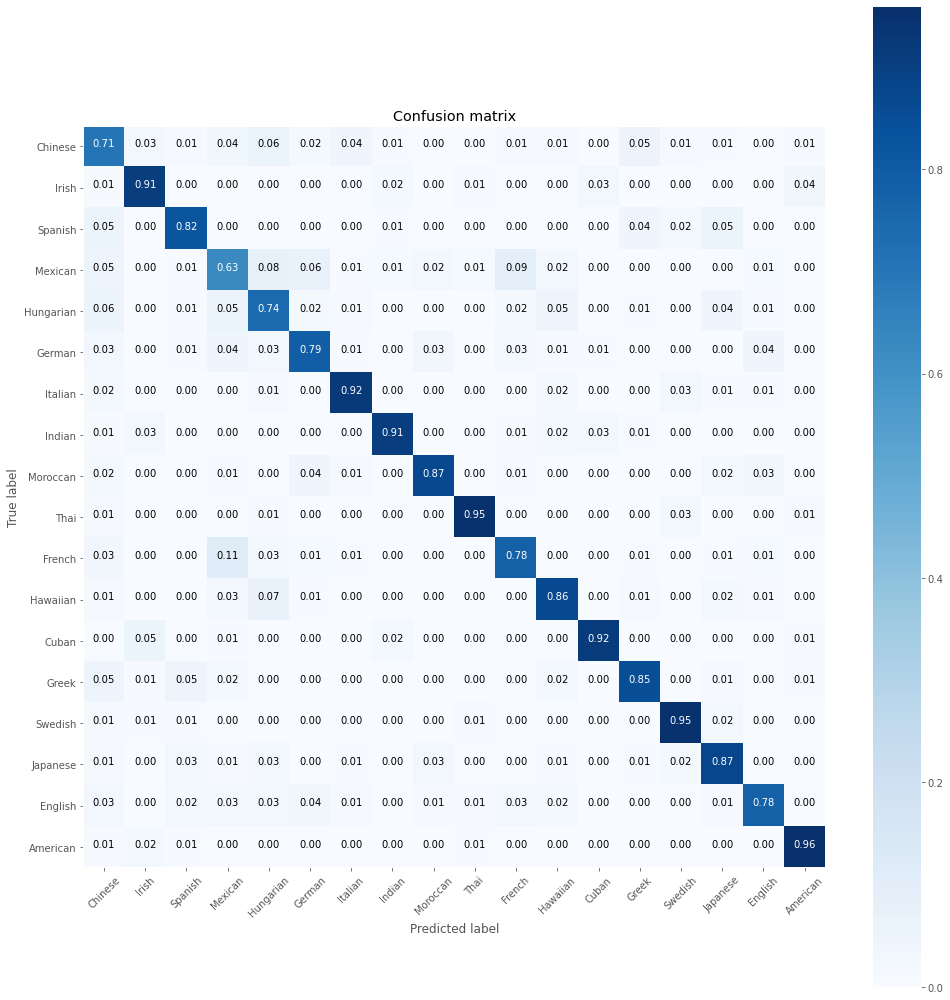

In [5]:
# Compute confusion matrix
y_pred = lr.predict(X_test)
cnf_matrix = confusion_matrix(y_test.values, y_pred)
np.set_printoptions(precision=2)

# Plot confusion matrix
plt.figure(figsize=(14,14))
plot_confusion_matrix(cnf_matrix, classes=labels,
                      title='Confusion matrix', normalize = True)

The confusion matrix can provide an overview of which cuisines were most difficult for the
model to classify correctly
- From the confusion matrix, it can be seen that Mexican cuisine has the lowest accuracy
and many recipes were misclassified as Hungarian or French
- All other recipes seem to have an accuracy above 70%
- For a better understanding of cross cultural influences between cuisines, I will use a
Sankey diagram

### 1.2 Sankey Diagram

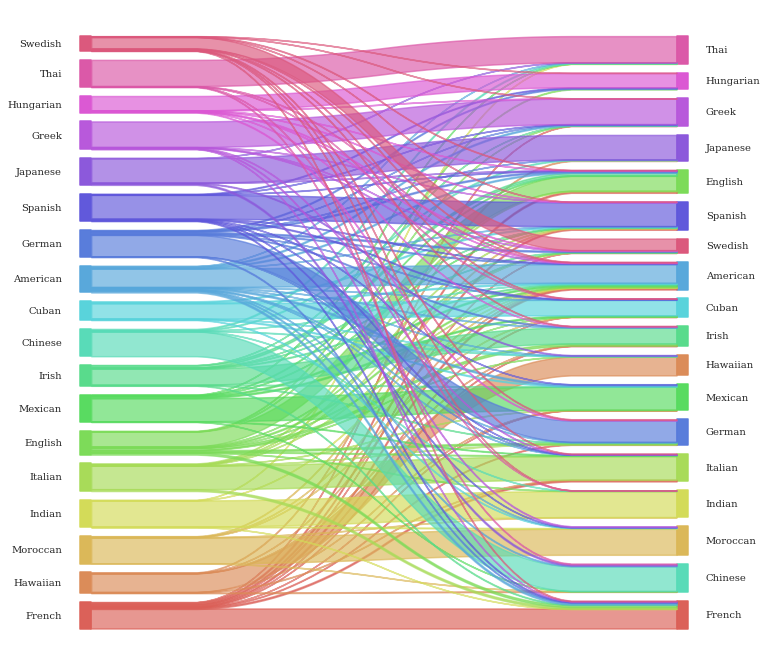

In [13]:
sankey_data = pd.DataFrame([y_test.values,y_pred], index = ['true', 'predicted']).T

sankey.sankey(sankey_data['true'], sankey_data['predicted'], aspect=30,
    fontsize=10)
plt.gcf().set_size_inches(12,12);

* On both sides of the sankey diagram, all the cuisines are listed. The cuisines on the left are the true cuisine labels, and on the right are the predicted cuisine labels. The size of the bar is proportional to how many recipes were classified to the given predicted cuisine. 
* From the sankey diagram, it is easy to see that a majority of the cuisines were predicted correctly
- Lets look at a sankey diagram of only recipes that were misclassified for better analysis

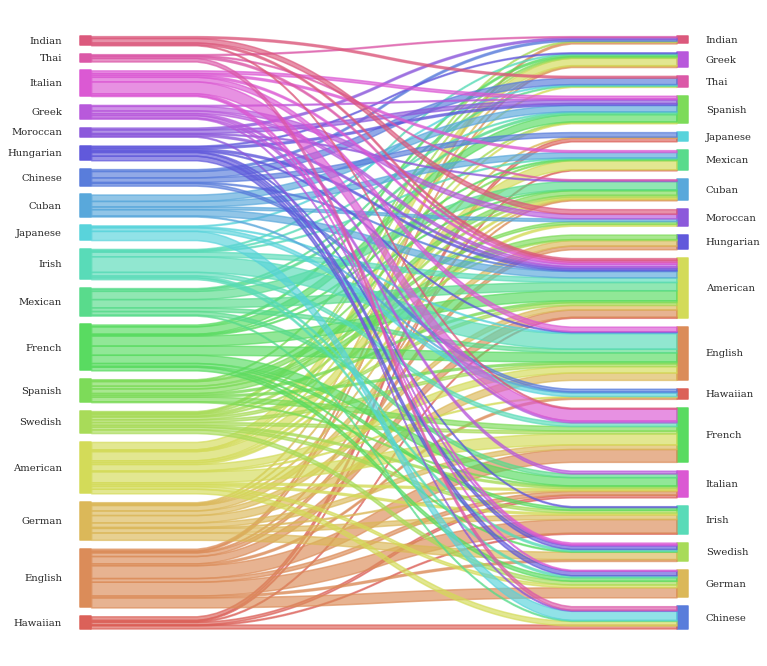

In [12]:
sankey_filtered = sankey_data[sankey_data['true']!=sankey_data['predicted']]

sankey.sankey(sankey_filtered['true'], sankey_filtered['predicted'], aspect=30,
    fontsize=10)
plt.gcf().set_size_inches(12,12);

* As a first observation, it is clear to see that most of the cuisines confused are geograhically close
* For example, Mexican cuisine (which had the highest misclassification rate) is mostly confused with American and Cuban cuisine, which makes sense given its geographic location
* Interestingly, almost all the Irish recipes that are misclassified are confused with English dishes, but English dishes are confused with Irish, French, German, and American dishes
* The sankey chart gives an interesting view of how cuisines influence each other



### 1.3 Coefficient Analysis

The coefficients of the logistic regression model can provide interesting insights on the most
distinctive ingredients for each cuisine
- Distinctive ingredients are ingredients which best help the logistic regression model
differentiate a particular cuisine from all other cuisines
- The tables below show the top 5 most distinct ingredient (i.e. ingredients with the
biggest coefficients in the logistic regression model) per cuisine

In [11]:
# Display a sample of most distinctive ingredients
df_dist_ing = None
cuisines = list(set(data.cuisine))
for i in range(len(cuisines)):
    top_features = [tvec.get_feature_names()[ing_id] for ing_id in np.argsort(-lr.coef_[i])[:20]]
    dist_ing_df_i = pd.DataFrame(data= {'Cuisine': data.cuisine.astype('category').cat.categories[i],
                                     'Most distinctive ingredients': top_features[:5]})
    display(dist_ing_df_i)

,Cuisine,Most distinctive ingredients
0,American,pecan
1,American,buttermilk
2,American,blue
3,American,bourbon
4,American,okra


,Cuisine,Most distinctive ingredients
0,Chinese,soy
1,Chinese,cornstarch
2,Chinese,sesame
3,Chinese,ginger
4,Chinese,hoisin


,Cuisine,Most distinctive ingredients
0,Cuban,plantain
1,Cuban,lime
2,Cuban,cumin
3,Cuban,garlic
4,Cuban,rum


,Cuisine,Most distinctive ingredients
0,English,stilton
1,English,pudding
2,English,beef
3,English,fish
4,English,pesto


,Cuisine,Most distinctive ingredients
0,French,thyme
1,French,cognac
2,French,tarragon
3,French,cheese
4,French,duck


,Cuisine,Most distinctive ingredients
0,German,sauerkraut
1,German,bratwurst
2,German,gingersnap
3,German,cabbage
4,German,lemon


,Cuisine,Most distinctive ingredients
0,Greek,feta
1,Greek,yogurt
2,Greek,oregano
3,Greek,lemon
4,Greek,lamb


,Cuisine,Most distinctive ingredients
0,Hawaiian,pineapple
1,Hawaiian,soy
2,Hawaiian,sauce
3,Hawaiian,papaya
4,Hawaiian,sesame


,Cuisine,Most distinctive ingredients
0,Hungarian,paprika
1,Hungarian,sour
2,Hungarian,noodle
3,Hungarian,onion
4,Hungarian,speck


,Cuisine,Most distinctive ingredients
0,Indian,curry
1,Indian,masala
2,Indian,turmeric
3,Indian,cardamom
4,Indian,yogurt


,Cuisine,Most distinctive ingredients
0,Irish,guinnes
1,Irish,potato
2,Irish,cabbage
3,Irish,beer
4,Irish,lamb


,Cuisine,Most distinctive ingredients
0,Italian,gnocchi
1,Italian,pasta
2,Italian,ravioli
3,Italian,parmesan
4,Italian,arborio


,Cuisine,Most distinctive ingredients
0,Japanese,mirin
1,Japanese,sake
2,Japanese,miso
3,Japanese,soy
4,Japanese,panko


,Cuisine,Most distinctive ingredients
0,Mexican,tortilla
1,Mexican,lime
2,Mexican,taco
3,Mexican,cheese
4,Mexican,salsa


,Cuisine,Most distinctive ingredients
0,Moroccan,harissa
1,Moroccan,cinnamon
2,Moroccan,cumin
3,Moroccan,couscou
4,Moroccan,preserved


,Cuisine,Most distinctive ingredients
0,Spanish,chorizo
1,Spanish,paprika
2,Spanish,olive
3,Spanish,sherry
4,Spanish,manchego


,Cuisine,Most distinctive ingredients
0,Swedish,cream
1,Swedish,meatball
2,Swedish,allspice
3,Swedish,cranberry
4,Swedish,breadcrumb


,Cuisine,Most distinctive ingredients
0,Thai,fish
1,Thai,curry
2,Thai,peanut
3,Thai,basil
4,Thai,chili


## 2. Recipe Recommendation System

The goal of this section was to identify ingredients that complement each other and to offer recipe suggestions to users based on the ingredients inputted.

For complementary ingredients, I compared two different algorithms: 
1. Pointwise Mutual Information (which calculates the likelihood of pairs of ingredients co-occurring) and 
2. word2vec (which uses recurrent neural networks to learn the relationship between words). 

It is difficult to quantify why algorithm performs better, as complementary ingredients are somewhat subjective, but there were very few overlaps between ingredients suggested by PMI and word2vec. Whereas personally, I found that PMI produced more relevant suggestions for complementary ingredients this would need to be further tested (possibly through hypothesis testing to see if the results from each algorithm are significantly different, or A/B testing to see which algorithm produces better results based on user feedback.

For the recipe recommendations, I used a content-based filtering approach, through which I can provide recipe recommendations to users based on the attributes (ingredients) they provide. To measure the similarity between recipes, I used TF-IDF to vectorize ingredients per recipe and calculated the cosine similarity between vectorized recipe ingredients. Because the relevance of a recommended recipe to a user is relative, there is no easy metric that can be used to evaluate the quality of the recommendations without user testing.

## 3. Business Recommendations

### 3.1 Cuisines and Ingredients 

Through EDA, there are many useful insights that can help HomeChef identify what type of ingredients and recipes are best to provide consumers. As most of the consumers of HomeChef would be novice home cooks looking for easy and convenient recipes, I would base recipe recommendations on the following factors:

* Number of ingredients: 
>Dishes in the dataset range between 2 to 40 ingredients. As the mean number of ingredients is 13, I would recommend HomeChef focus on recipes that use between 10-15 ingredients, and excluding common ingredients that are present across all cuisines and most likely consumers would already have in their kitchens (such as salt, pepper, onions, and garlic)

* Recipe rating: 
>Italian, Mexican, Chinese, Thai, Greek, and Indian are cuisines with the highest average recipe ratings (the mean for these cuisines is above 3.9 out of 5). A higher recipe rating most likely correlates with tastier dishes, and recipes that are easier for users to make. It is worth noting that the data is from Yummly, where users are primarily American and therefore the ratings maybe biased towards American preferences.

* Cooking time: 
> Dishes in this dataset range from a cooking time of 10 minutes to almost 9000 minutes (for recipes that use slow cookers or involve pot roasts). As the 25 th percentile is 35 minutes and the 75th percentile is 75 minutes, I would suggest providing users with recipes that take between 35 to 75 minutes to make. Therefore I would focus on cuisines where at least 75% of recipes will take under 60 minutes to make. These cuisines are: Indian, Greek, Italian, Hawaiian, Mexican, Japanese, Chinese, and Thai


Based on the criteria above, as well as the clustering analysis, I would suggest HomeChef focus
on the following 5 cuisines:
1. Mexican
2. Italian
3. Chinese
4. Indian
5. French

These cuisines generally have high recipe ratings, manageable cooking times, and have
distinguishable ingredients (the cuisines belong to different K-Means clusters) so consumers will
have options in terms of taste preferences and will not get bored as easily. While French recipes tend to have a longer cooking time (only 50% of French recipes take under 60 minutes to cook), it is the only cuisine from the European region cluster with an average rating above 3.8. Consumers that are looking for a challenge can try selecting French recipes.

Based on these cuisines, HomeChef can also ensure to stock up on ingredients that have a high
relative usage for each cuisine. These ingredients are:
1. Mexican: queso fresco, guacamole, tomatillo, masa harina, and salsa
2. Italian: lasagna, meat sauce, pecorino cheese, ricotta cheese, and pasta sauce
3. Chinese: black vinegar, hoisin sauce, fivespice powder, tangerine, and oyster sauce
4. Indian: mutton, cassia leaves, rose water, cardamom, and black salt
5. French: endive, armagnac brandy, pinot noir, bouquet garni (herbs), and lavendar

### 3.2 Recipe Recommendation System

I have deployed a telegram bot as a prototype of some of the features that HomeChef will
be able to provide its consumers. Consumers can input what ingredients they have on hand,
and be offered suggestions for cuisines and recipes to cook based on the logistic regression
cuisine classifier and content based recipe recommendation system. The telegram bot can
be useful to provide consumers who want to buy ingredients a la carte from HomeChef’s
marketplace with suggestions on what other ingredients to add to their cart, or provide
consumers with inspiration on what cuisine or recipes to cook next.

The bot can be downloaded [here](https://t.me/recs4homechefs_bot)

## 4. Further Steps

The recipes used to gain insight on cuisines and develop the models for this project are from a
single source, Yummly. In order to make the model more robust, it would be good to collect
recipes from other sources too, especially websites that are popular in different regions so that I
can have a full scope of taste preferences and variations.

Furthermore, sentiment analysis on their target consumer base may help HomeChef evaluate
how their audience will receive certain cuisines and recipes. For example, as HomeChef is
looking to target young, working class people in Singapore who do not much experience with
cooking, would this consumer base be interested in learning to cook Asian recipes that they may
be already familiar with, or would they want to experiment cooking recipes that are slightly
more exotic).

Lastly, we would want to collect user feedback in order to evaluate the performance of the
recipe recommendation system. HomeChef could use A/B testing to see if providing recipe
suggestions increases the number of ingredients users purchase from their marketplace, or if
HomeChef collects reviews and ratings on the recipes they provide this could be used to build a
more personalized recipe recommendation system in the future.